In [ ]:
!pip install datasets
!pip uninstall torch torchvision torchaudio -y
!pip install transformers
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: torchvision 0.18.0
Uninstalling torchvision-0.18.0:
  Successfully uninstalled torchvision-0.18.0
Found existing installation: torchaudio 2.6.0
Uninstalling torchaudio-2.6.0:
  Successfully uninstalled torchaudio-2.6.0


In [1]:


import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torch
import torchaudio

import os
import sys

from datasets import load_dataset
from transformers import AutoConfig, Wav2Vec2FeatureExtractor

from sklearn.metrics import classification_report

c:\Users\Ranadeep Mahendra\anaconda3\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:

# Base directory where audio files are stored
base_path = "E:\\assignments\\projects\\data"

# Function to dynamically get folder paths for each person's audio files
def get_audio_folder_mapping(category):
    folder_path = os.path.join(base_path, category)  # e.g., "dementia" or "nodementia"
    folder_to_paths = {}

    for folder in os.listdir(folder_path):  # Loop over folders (people's names)
        person_path = os.path.join(folder_path, folder)
        if os.path.isdir(person_path):  # Ensure it's a folder
            folder_to_paths[folder] = person_path  # Store the folder path

    return folder_to_paths

# Get all available folders for dementia and no dementia
dementia_folders = get_audio_folder_mapping("dementia")
nodementia_folders = get_audio_folder_mapping("nodementia")

# Combine both mappings
all_audio_folders = {**dementia_folders, **nodementia_folders}

# Load predefined train and test splits from CSV files
train_csv = pd.read_csv("train.csv")
test_csv = pd.read_csv("test.csv")

# Convert to structured dataset (store only folder paths)
# Convert to structured dataset (store only folder paths)
file_data = []
for person, folder_path in all_audio_folders.items():
    # Check if the person is in train.csv or test.csv and use the actual label
    if person in train_csv["file"].values:
        label = train_csv[train_csv["file"] == person]["label"].values[0]
    elif person in test_csv["file"].values:
        label = test_csv[test_csv["file"] == person]["label"].values[0]
    else:
        continue  # Skip if the person is not found in train or test CSV

    file_data.append({"file": person, "label": label, "path": folder_path})

# Convert to DataFrame
audio_dataset = pd.DataFrame(file_data)

# Filter dataset using the predefined train and test splits
train_data = audio_dataset[audio_dataset["file"].isin(train_csv["file"])]
test_data = audio_dataset[audio_dataset["file"].isin(test_csv["file"])]

# Save the fixed dataset
train_data.to_csv("train_dataset_fixed.csv", index=False)
test_data.to_csv("test_dataset_fixed.csv", index=False)

# Load the dataset dynamically
data_files = {
    'train': "train_dataset_fixed.csv",
    'valid': "test_dataset_fixed.csv"
}

# Load the dataset using Hugging Face's `datasets` library
from datasets import load_dataset
dataset = load_dataset("csv", data_files=data_files)

train_data = dataset['train']
test_data = dataset['valid']

# Verify column names and ensure train-test split is correct
print(f"Train Dataset Columns: {train_data.column_names}")  # ['file', 'label', 'path']
print(f"Train Rows: {len(train_data)}, Test Rows: {len(test_data)}")
print(f"Unique Persons in Train: {len(set(train_data['file']))}, Unique Persons in Test: {len(set(test_data['file']))}")

# Ensure no overlapping persons between train and test
overlapping_files = set(train_data["file"]).intersection(set(test_data["file"]))
print(f"Persons in both train and test: {overlapping_files}")  # Should print an empty set


Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Train Dataset Columns: ['file', 'label', 'path']
Train Rows: 62, Test Rows: 64
Unique Persons in Train: 62, Unique Persons in Test: 64
Persons in both train and test: set()


In [3]:
input_col = 'path'
output_col = 'label'

In [4]:
label_list = train_data.unique(output_col)
label_list.sort()
num_classes = len(label_list)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_list}")

Number of classes: 4
Classes: ['five years to dementia', 'no dementia', 'ten years to dementia', 'zero years to dementia']


In [5]:
print(train_data.column_names)


['file', 'label', 'path']


In [6]:
num_labels=num_classes,
label2id={label: i for i, label in enumerate(label_list)},
id2label={i: label for i, label in enumerate(label_list)},

In [7]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput

@dataclass
class SpeechClassifierModelOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [8]:
import torch
import torch.nn as nn
from transformers.models.wav2vec2.modeling_wav2vec2 import (Wav2Vec2PreTrainedModel, Wav2Vec2Model)

class Wav2Vec2ClassificationHead(nn.Module):
    """head for wav2vec classification task"""
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dense(x)
        x = self.dropout(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merge_strategy(self, hidden_states, mode="mean"):
        if mode == "mean":
            return torch.mean(hidden_states, dim=1)
        elif mode == "max":
            return torch.max(hidden_states, dim=1)[0]
        elif mode == "sum":
            return torch.sum(hidden_states, dim=1)
        else:
            raise ValueError(f"Unknown merge strategy: {mode}")

    def forward(
        self,
        input_values,
        attention_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(input_values,
                            attention_mask=attention_mask,
                            output_attentions=output_attentions,
                            output_hidden_states=output_hidden_states,
                            return_dict=return_dict)

        hidden_states = outputs[0]
        hidden_states = self.merge_strategy(hidden_states, self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierModelOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [10]:
model_name_or_path = "RanadeepMahendra/wav2vec2-large-xls-r-300m-dm32"
config = AutoConfig.from_pretrained(model_name_or_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

config.json:   0%|          | 0.00/2.29k [00:00<?, ?B/s]

c:\Users\Ranadeep Mahendra\anaconda3\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ranadeep Mahendra\.cache\huggingface\hub\models--RanadeepMahendra--wav2vec2-large-xls-r-300m-dm32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

In [11]:
'''def speech_to_array(batch):
    speech, sr = torchaudio.load(batch["path"])
    transform = torchaudio.transforms.Resample(sr, 16000)
    speech = transform(speech)[0].numpy().squeeze()
    batch["speech"] = speech
    #return random_subsample(speech, max_length=8)
    return batch'''

import os
import torchaudio

import torchaudio
import os

def speech_to_array(batch):
    folder_path = batch["path"]  # This now points to the folder
    audio_data = []

    # Process all WAV files inside the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            try:
                speech, sr = torchaudio.load(file_path)
                transform = torchaudio.transforms.Resample(sr, 16000)
                speech = transform(speech)[0].numpy().squeeze()
                audio_data.append(speech)  # Store all audio data
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    batch["speech"] = audio_data if audio_data else None  # Store all audio files
    return batch
def predict(batch):
    print("Batch size:", len(batch["speech"]))  # Debug batch size
    print("Each speech sample length:", [len(s) for s in batch["speech"]])

    # Ensure all sequences have the same length by padding
    max_len = max(len(s) for s in batch["speech"])
    padded_speech = [np.pad(s, (0, max_len - len(s)), mode="constant") for s in batch["speech"]]

    features = feature_extractor(
        padded_speech,  
        sampling_rate=feature_extractor.sampling_rate, 
        return_tensors="pt", 
        padding="max_length",  # Ensures uniform shape
        truncation=True,
        max_length=16000  # Adjust this value based on dataset
    )

    input_values = features.input_values.to(device)

    with torch.no_grad():
        logits = model(input_values).logits

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    return {"predicted": pred_ids}


In [12]:
import os
missing_files = [path for path in test_data["path"] if not os.path.exists(path)]
print(f"Missing Files: {len(missing_files)}")


Missing Files: 0


In [13]:
print(test_data.column_names)


['file', 'label', 'path']


In [97]:
!pip3 install PySoundFile

   ---------------------------------------- 0.0/671.8 kB ? eta -:--:--
   ---------------------------------------- 671.8/671.8 kB 6.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
test_data = test_data.map(speech_to_array, None)

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

In [15]:
import numpy as np

def fix_speech_data(batch):
    fixed_speech = []
    
    for speech in batch["speech"]:
        # Convert to NumPy array if it's a list
        if isinstance(speech, list):
            # Flatten only if elements inside are lists
            if any(isinstance(i, list) for i in speech):
                speech = np.concatenate([np.array(i) for i in speech], axis=0)  # Merge sublists
            else:
                speech = np.array(speech)  # Convert normally
        
        # Convert to NumPy array if it isn't already
        elif not isinstance(speech, np.ndarray):
            print(f"Unexpected type found: {type(speech)}")
            continue  # Skip invalid samples
        
        # Ensure it's a 1D array
        speech = speech.flatten()

        if len(speech) > 0:  # Skip empty samples
            fixed_speech.append(speech)

    batch["speech"] = fixed_speech
    return batch


In [16]:
test_data = test_data.map(fix_speech_data, batched=True, batch_size=8)

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

In [17]:
result = test_data.map(predict, batched=True, batch_size=8, remove_columns=["speech"])


Parameter 'function'=<function predict at 0x0000021AF3992F70> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Batch size: 8
Each speech sample length: [1136315, 2800000, 2672000, 1440000, 3024000, 2832000, 848363, 1504156]
Batch size: 8
Each speech sample length: [608092, 928279, 1120134, 2496068, 736000, 2880084, 560253, 928324]
Batch size: 8
Each speech sample length: [160000, 144327, 1488550, 2880000, 1376413, 560144, 752289, 768164]
Batch size: 8
Each speech sample length: [2184000, 672359, 1600283, 768000, 1488332, 1984000, 640000, 1264000]
Batch size: 8
Each speech sample length: [2464268, 1376108, 2880399, 1792000, 1504453, 864063, 496012, 1632015]
Batch size: 8
Each speech sample length: [256366, 704000, 2304438, 288000, 1296480, 544252, 1440009, 1440000]
Batch size: 8
Each speech sample length: [1440000, 2336000, 1264000, 1072000, 1440000, 1056000, 1696000, 2272000]
Batch size: 8
Each speech sample length: [2592000, 4320000, 1440000, 1216000, 3008000, 1440000, 2768000, 2816000]


In [18]:
label_list

['five years to dementia',
 'no dementia',
 'ten years to dementia',
 'zero years to dementia']

In [19]:
print(set(result["label"]))  # Show unique labels in dataset


{'no dementia', 'zero years to dementia', 'ten years to dementia', 'five years to dementia'}


In [20]:
# Ensure correct label mappings
label_list = ['five years to dementia', 'no dementia', 'ten years to dementia', 'zero years to dementia']
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

# Print label mappings for verification
print("Label to ID mapping:", label2id)
print("ID to Label mapping:", id2label)

# Ensure all labels are mapped correctly
y_true_labels = list(result["label"])  # Convert tuple-like object to a list
y_true = [label2id[name] for name in y_true_labels]  # Convert label names to numerical IDs
y_pred = list(result["predicted"])  # Ensure predictions are also in list format

# Convert back to label names for verification
y_pred_labels = [id2label[id] for id in y_pred]  # Convert predictions to label names

# Print mapped IDs and predictions
print("y_true (Numerical IDs):", y_true)  
print("y_pred (Numerical Predictions):", y_pred)  

# Display correct classifications
for i in range(len(y_true)):
    if y_pred_labels[i] == y_true_labels[i]:
        print(f"{y_true_labels[i]} -> {y_pred_labels[i]}")

# Compute accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))


Label to ID mapping: {'five years to dementia': 0, 'no dementia': 1, 'ten years to dementia': 2, 'zero years to dementia': 3}
ID to Label mapping: {0: 'five years to dementia', 1: 'no dementia', 2: 'ten years to dementia', 3: 'zero years to dementia'}
y_true (Numerical IDs): [3, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 3, 2, 0, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 2, 3, 2, 3, 3, 3, 3, 0, 0, 3, 2, 3, 3, 3, 0, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y_pred (Numerical Predictions): [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1]
five years to dementia -> five years to dementia
no dementia -> no dementia
no dementia -> no dementia
no dementia -> no dementia
no dementia -> no dementia
no dementia -> no dementia
no dementia -> no dementia
no dementia -> no dementia
no dementia -> no dementia
no dementia -> no dementia
no dementia ->

In [21]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=label_list)
cf_matrix

array([[ 1,  5,  0,  0],
       [ 3, 12,  0,  0],
       [ 7,  6,  0,  0],
       [ 6, 24,  0,  0]], dtype=int64)

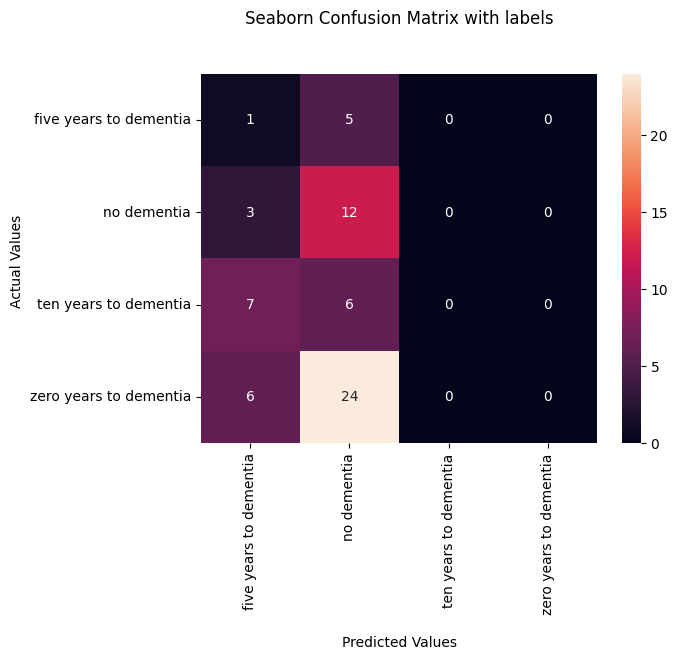

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline as mpl

cm = pd.DataFrame(cf_matrix, index = [i for i in label_list], columns = [i for i in label_list])
ax = sns.heatmap(cm, annot=True)

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [23]:
print(classification_report(y_true, y_pred, target_names=label_list))

                        precision    recall  f1-score   support

five years to dementia       0.06      0.17      0.09         6
           no dementia       0.26      0.80      0.39        15
 ten years to dementia       0.00      0.00      0.00        13
zero years to dementia       0.00      0.00      0.00        30

              accuracy                           0.20        64
             macro avg       0.08      0.24      0.12        64
          weighted avg       0.07      0.20      0.10        64



c:\Users\Ranadeep Mahendra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ranadeep Mahendra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ranadeep Mahendra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
